# Station interpolation

Use-Case: Moving sensors -> simulate bus stop with different intervals and rest durations

Select one station that and set time interval. Interpolate missing values by regressor with training from surrounding stations.

In [251]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
from matplotlib.lines import Line2D

crs = 'EPSG:3857'
crs_plot = 'EPSG:4326'

# # DWD Reference
# # 53.6332;9.9881

df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])
qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
    'lat', 'lon']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs)

# qc_gdf = qc_gdf.to_crs(crs)
qc_gdf.drop('z', axis=1, inplace=True)

m5_gdf = qc_gdf[qc_gdf['m5'] == True]
rest_gdf = qc_gdf[qc_gdf['m5'] == False]

# print(qc_gdf)

## Plotting QC

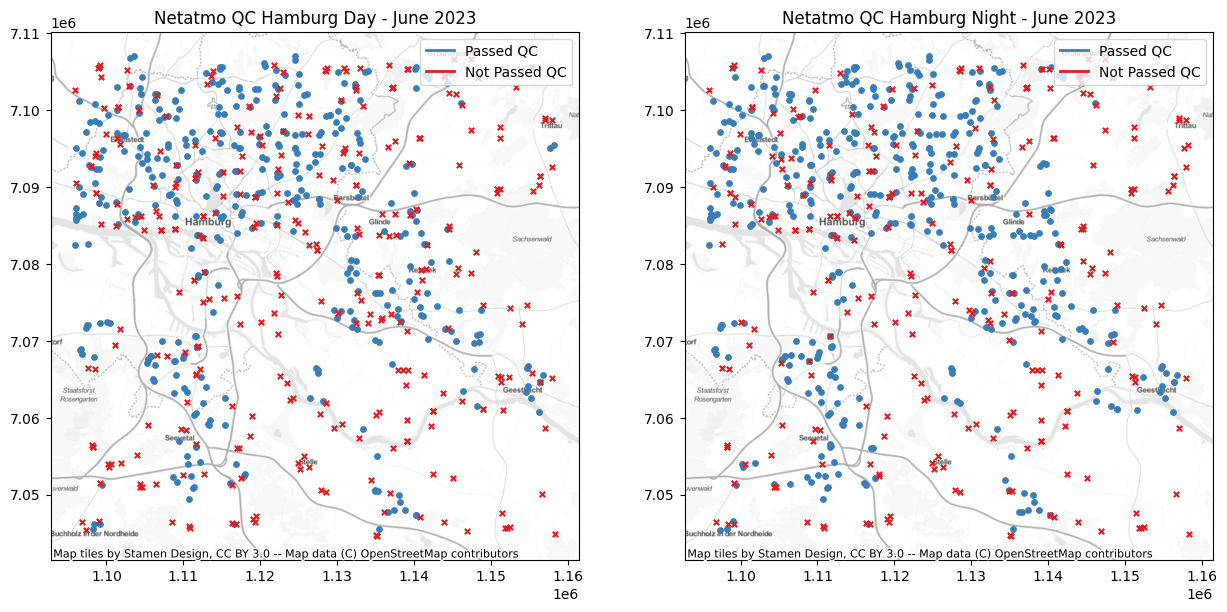

In [88]:
def plot_qc_locations(gdf1, gdf2, title, ax):
    gdf1.plot(marker='o', ax=ax, markersize=15, color='#377eb8')
    gdf2.plot(marker='x', ax=ax, markersize=15, color='#e41a1c' )

    custom_lines = [Line2D([0], [0], color='#377eb8', lw=2),
                    Line2D([0], [0], color='#e41a1c', lw=2)]

    ax.legend(handles=custom_lines, labels=['Passed QC', 'Not Passed QC'], loc='upper right')

# Set axis title and add basemap
    ax.set_title(title)
    ctx.add_basemap(
    ax,
    crs=crs,
    alpha=0.7,
    source=ctx.providers.Stamen.TonerLite
)

# Plot gdf
fig, axs = plt.subplots(1, 2, figsize=(15,8))

# Filter by time because first time everything is false
m5_gdf_day = m5_gdf[m5_gdf['time'] == '2023-06-19 14:00:00']
rest_gdf_day = rest_gdf[rest_gdf['time'] == '2023-06-19 14:00:00']

plot_qc_locations(m5_gdf_day, rest_gdf_day, 'Netatmo QC Hamburg Day - June 2023', axs[0])

m5_gdf_night = m5_gdf[m5_gdf['time'] == '2023-06-19 02:00:00']
rest_gdf_night = rest_gdf[rest_gdf['time'] == '2023-06-19 02:00:00']

plot_qc_locations(m5_gdf_night, rest_gdf_night, 'Netatmo QC Hamburg Night - June 2023', axs[1])

Text(0.5, 0, 'Date')

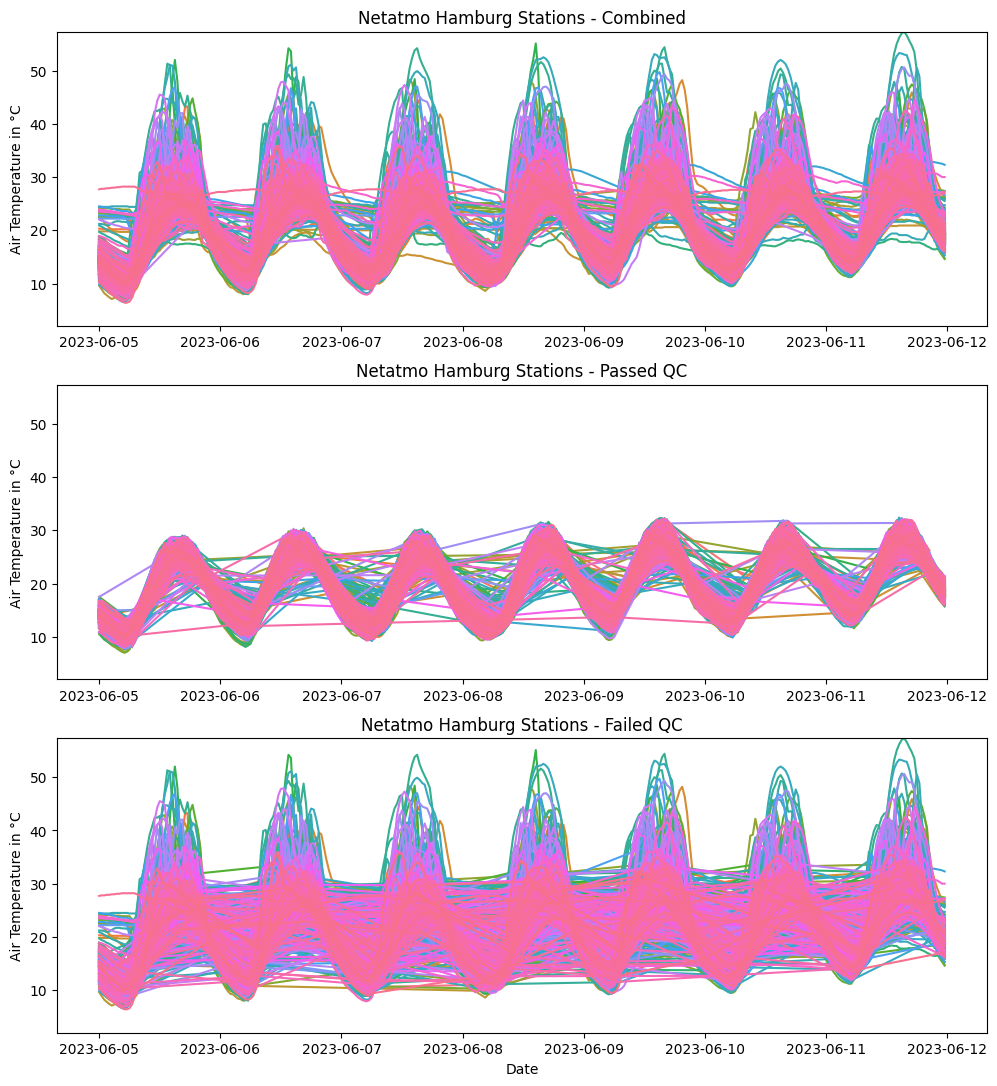

In [98]:
import seaborn as sns
import matplotlib.dates as md

# Plot lines of temperature of stations

# Plot daily_mean_temp_2m as line plot
fig, axs = plt.subplots(3, 1, figsize=(12, 13))
ymin, ymax = qc_gdf.ta.min(), qc_gdf.ta.max()

def plot_stations_ta(gdf, ax, title):
    grouped_df = gdf.groupby([pd.Grouper(key='p_id'), pd.Grouper(key="time", freq="10T")]).agg({'ta': 'first'})

    sns.lineplot(x='time', 
             y='ta',
             hue='p_id', 
             data=grouped_df,
             ax=ax,
             legend=False)
    ax.set_ylabel('Air Temperature in °C')
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(None)
    ax.set_title(title)

plot_stations_ta(qc_gdf[(qc_gdf['time'] >= '2023-06-05') & (qc_gdf['time'] < '2023-06-12')], axs[0], 'Netatmo Hamburg Stations - Combined')
plot_stations_ta(m5_gdf[(m5_gdf['time'] >= '2023-06-05') & (m5_gdf['time'] < '2023-06-12')], axs[1], 'Netatmo Hamburg Stations - Passed QC')
plot_stations_ta(rest_gdf[(rest_gdf['time'] >= '2023-06-05') & (rest_gdf['time'] < '2023-06-12')], axs[2], 'Netatmo Hamburg Stations - Failed QC')

axs[2].set_xlabel('Date')

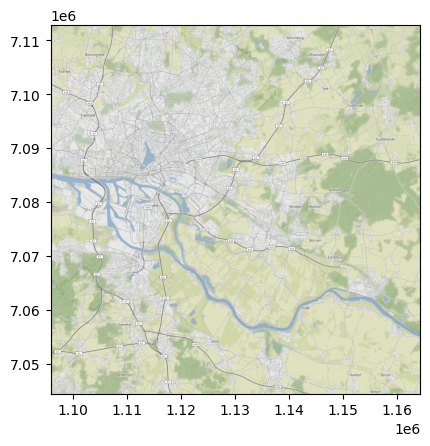

In [29]:
import seaborn as sns
import matplotlib.dates as md

# Hamburg - Location
lat, lon = 53.592580,9.924545
ymin, ymin, ymax, ymax = lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01

crs = 'EPSG:4326'

# # DWD Reference
# # 53.6332;9.9881

# lat1, lon1 = 53.65, 9.8
# lat2, lon2 = 53.53, 10.05

# # # Create a bounding box geometry
bounding_box = box(ymin, ymax, ymax, ymin)

slice_gdf = m5_gdf[m5_gdf.geometry.within(bounding_box)]

w, s, e, n = slice_gdf.to_crs(epsg=3857).total_bounds

## Dataset Creation For ML

In [252]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC


time_step = pd.Timestamp('2023-06-05 14:00:00', tz=UTC).to_datetime64()

filtered_gdf = m5_gdf[m5_gdf['time'] == time_step]

entry = filtered_gdf.iloc[0]

print(entry.p_id)

nearest_neighbors_count = 10
feature_count = 1

# Build neighbor tree
locations = list(filtered_gdf.geometry.apply(lambda x: (x.x, x.y)))

print('Building tree...')
# More build time but better query time
tree = KDTree(locations, balanced_tree=True)

# Get nearest neighbors including current location, euclidean distance
dist, idx = tree.query(entry[-1].coords, k=nearest_neighbors_count + 1, p=2)

# First entry is the point itself
idx = idx[0]
dist = dist[0]

# Drop Timestamp and geometry
gdB_nearest = filtered_gdf.iloc[idx]

neighbour_ids = gdB_nearest['p_id'].reset_index(drop=True)
print(neighbour_ids)

neighbours_gdf = m5_gdf[m5_gdf['p_id'].isin(gdB_nearest['p_id'])]
print(neighbours_gdf)

70:ee:50:00:1e:4c
Building tree...
0     70:ee:50:00:1e:4c
1     70:ee:50:73:b7:a2
2     70:ee:50:27:8d:72
3     70:ee:50:96:d5:62
4     70:ee:50:20:fd:10
5     70:ee:50:71:4d:4a
6     70:ee:50:17:4e:ec
7     70:ee:50:3a:38:94
8     70:ee:50:1f:68:a2
9     70:ee:50:7a:f0:6a
10    70:ee:50:90:a4:d6
Name: p_id, dtype: object
                     p_id                time        lon        lat  pressure  \
1440    70:ee:50:00:1e:4c 2023-06-01 01:00:00  53.624649  10.143038    1025.1   
1441    70:ee:50:00:1e:4c 2023-06-01 01:30:00  53.624649  10.143038    1025.1   
1442    70:ee:50:00:1e:4c 2023-06-01 02:00:00  53.624649  10.143038    1025.1   
1443    70:ee:50:00:1e:4c 2023-06-01 02:30:00  53.624649  10.143038    1025.1   
1444    70:ee:50:00:1e:4c 2023-06-01 03:00:00  53.624649  10.143038    1025.1   
...                   ...                 ...        ...        ...       ...   
997915  70:ee:50:96:d5:62 2023-06-30 22:30:00  53.626973  10.151728    1022.2   
997916  70:ee:50:96:d5:62 2

In [256]:
import csv

start = pd.Timestamp('2023-06-01 09:00:00', tz=UTC)
end = start + pd.Timedelta(days=14)

columns = ['y']
columns.extend(['ta_' + str(i) for i in range(1, nearest_neighbors_count + 1)])
columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])

X = pd.DataFrame(columns=columns)
X.reset_index(drop=True, inplace=True)

for date in pd.date_range(start=start, end=end, freq='30min'):
    start_time = date.to_datetime64()
    end_time = start_time + pd.Timedelta(minutes=30)

    filtered_gdf = neighbours_gdf[(neighbours_gdf['time'] >= start_time) & (neighbours_gdf['time'] < end_time)]
    filtered_gdf.set_index('p_id', inplace=True)

    # Convert time to time of day
    filtered_gdf['time_angle'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))

    # Calculate continuous representation of time as an angle in radians
    filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
    filtered_gdf['cos_time'] = np.cos(filtered_gdf['time_angle'])

    nr_cols = nearest_neighbors_count + feature_count + 1
    x = np.empty(nr_cols, dtype=object)
    x[:] = np.nan

    for index, neighbour in neighbour_ids.items():
        if neighbour_ids[index] in filtered_gdf.index:
            x[index] = filtered_gdf.loc[neighbour_ids[index]].ta
    
    x[-1] = filtered_gdf['sin_time'].values[0]
    x = x.reshape(1, nr_cols)

    new = pd.DataFrame(x, columns=columns)
    
    X = pd.concat([X, new], axis=0, ignore_index=True)
    
# df.sample(frac = 0.3, random_state = 42)
print(X)

X.to_csv('./data/hamburg_dataset_ml.csv', index=False)


/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set 

        y  ta_1  ta_2  ta_3  ta_4  ta_5  ta_6  ta_7  ta_8  ta_9 ta_10  \
0    12.6  13.1  12.2  12.5  13.5   NaN  13.5  13.1  12.6  12.0  12.3   
1    12.9  13.5  12.4  12.8  13.9   NaN  13.6  13.5  12.9  12.3  12.4   
2    13.2  13.9  12.7  13.0  13.9   NaN  13.9   NaN  13.2   NaN  12.5   
3    13.6  14.3  13.2  13.4  14.1   NaN  14.5  14.6  13.8   NaN  12.8   
4    14.2  14.9  13.6  13.8  14.5   NaN  14.3   NaN  14.3   NaN   NaN   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
668  13.5  13.2  11.8  13.8   NaN  12.8  13.3  13.9  13.2  12.7  12.5   
669  14.8  14.3  12.8  14.6   NaN  13.3  14.4  14.8  14.2  13.4  13.3   
670  16.3  15.7  14.2  15.7   NaN  14.3  15.7  15.9  15.6  14.4  14.7   
671  17.5  16.8  15.7  16.8   NaN  15.5  17.2  17.0  17.2  15.6  15.9   
672  18.9  17.9  17.2  17.8   NaN  16.7  18.7  18.0  21.1  16.9  17.1   

    feature_1  
0    0.707107  
1    0.608761  
2         0.5  
3    0.382683  
4    0.258819  
..        ...  
668  0.9659

/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set 

# ML Model Eval

In [267]:
# Create test dataset
from pytz import UTC
from scipy.spatial import KDTree
from shapely.geometry import Point
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/hamburg_dataset_ml.csv')

df.dropna(subset=['y'], inplace=True)

X = df.drop(['y'], axis=1)
y = df.y.values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=1, shuffle=True)

print(X_train)
print(y_train)

     ta_1  ta_2  ta_3  ta_4  ta_5  ta_6  ta_7  ta_8  ta_9  ta_10  feature_1
594   NaN  23.8  23.3  25.8   NaN  26.5  24.1  24.2  24.4   23.7  -1.000000
75    NaN  13.8  14.3   NaN   NaN  14.3  14.2  14.1  12.3   13.4  -0.382683
399   NaN  27.5  25.6  26.8  28.8  29.9  26.9  27.6  28.2   26.5  -0.923880
609  16.5  15.3  15.9   NaN  16.0  15.6  15.7  15.7  15.4   15.2   0.382683
126   NaN  12.1   NaN   NaN   NaN  13.0  12.7  12.7  13.2   12.8   0.000000
..    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...        ...
137   9.4   7.5   NaN   NaN   NaN   8.9   8.9   8.7   9.5    8.6   0.991445
152  20.1  20.8  19.5  19.9   NaN  21.1  19.2  22.5  22.4   20.6  -0.258819
79   13.1  10.8  12.8   NaN   NaN  11.9  12.2  11.3  11.1   11.0   0.130526
243  19.5  19.9  19.1  20.7  18.8  20.1  18.7   NaN  17.7   18.4   0.382683
39    9.9   9.7  10.7   NaN   NaN   9.9  10.1   9.7  10.1   10.2   0.923880

[448 rows x 11 columns]
[25.9 14.  29.  15.9 13.2 14.2 21.  16.7 26.6 12.4 14.6 29.  23

In [269]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

## KNN
normalize = False

X_train_norm = X_train
X_test_norm = X_test

if normalize:
    scaler_X = StandardScaler().fit(X_train)
    X_train_norm = scaler_X.transform(X_train)
    X_test_norm = scaler_X.transform(X_test)

regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
regr.fit(X_train_norm, y_train)
y_pred = regr.predict(X_test_norm)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R2: %.2f" % r2)

print("X Input: ", X_test[:5])

print("Predicted: ", y_pred[:5])
print("Actual: ", y_test[:5])

MAE: 0.30
MSE: 0.19
RMSE: 0.43
R2: 0.99
X Input:       ta_1  ta_2  ta_3  ta_4  ta_5  ta_6  ta_7  ta_8  ta_9  ta_10  feature_1
140  10.4   9.1  11.3   NaN   NaN  10.4  10.4  10.0  10.0    9.5   0.965926
655   NaN  15.8   NaN   NaN  16.6  16.1  16.8  16.0  16.3   15.9   0.130526
552   NaN  23.2  23.5   NaN  24.9  24.8  23.2  23.9  23.4   23.3  -0.707107
298  24.0  24.1  26.1  23.0  23.6  24.9  22.5  25.7   NaN   24.0  -0.500000
89    8.2   6.6   NaN   NaN   NaN   7.4   7.8   7.2   7.9    7.8   0.991445
Predicted:  [10.05403507 16.37135018 24.84112511 26.42124768  8.37853297]
Actual:  [10.4 16.4 24.3 25.5  7.7]
